In [1]:
# Needed to switch directory in Google drive so as to import CDA env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
     |████████████████████████████████| 1.2MB 2.7MB/s 
     |████████████████████████████████| 112kB 61.2MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 829kB 61.3MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 1.6MB 61.5MB/s 
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Cloning https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git (to revision c897137cbcc93ca71cbd51c27e683c3298

Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, google-pasta, grpcio, protobuf, six, astor, keras-applications, opt-einsum, gast, tensorboard, termcolor, wheel, absl-py, scipy, wrapt, tensorflow-estimator, keras-preprocessing
Required-by: fancyimpute
Name: ray
Version: 0.8.2
Summary: A system for parallel and distributed Python that unifies the ML ecosystem.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, aiohttp, colorama, google, click, cloudpickle, filelock, numpy, jsonschema, packaging, py-spy, redis, grpcio, protobuf, pytest, funcsigs, pyyaml
Required-by: 


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import create_storage, create_train_policy_list
from gym_continuousDoubleAuction.train.logger.log_handler import file_num, log_json, load_json
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_step_result, plot_eps_result, show_obs
#from gym_continuousDoubleAuction.train.helper.helper import str_to_arr

tf = try_import_tf()

In [3]:
# global

# CDA_env args
num_agents = 5
num_trained_agent = 2 # 1st 2
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 300 # per episode, -1 in arg. (7.2s/1000steps/iter)
is_render = False

# step storages
obs_step_store = create_storage(num_agents, "agt_", "_obs_step_list")
reward_step_store = create_storage(num_agents, "agt_", "_reward_step_list")
NAV_step_store = create_storage(num_agents, "agt_", "_NAV_step_list")
num_trades_step_store = create_storage(num_agents, "agt_", "_num_trades_step_list")

# episodic storages
policy_reward_store = create_storage(num_agents, "agt_", "_policy_reward_list")
reward_store = create_storage(num_agents, "agt_", "_reward_list")
NAV_store = create_storage(num_agents, "agt_", "_NAV_list")
num_trades_store = create_storage(num_agents, "agt_", "_num_trades_list")

# storage for json input
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
num_workers = 1
num_envs_per_worker = 2
sample_batch_size = 32
train_batch_size = 128
num_iters = 7
log_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/ray_results/"

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 100
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False

# log & load 
write_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/eps_data/"

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-03-31 07:42:45,758	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-31 07:42:45,760	INFO resource_spec.py:212 -- Starting Ray with 7.13 GiB memory available for workers and up to 3.58 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1']


2020-03-31 07:42:46,199	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-03-31_07-42-45_757496_402/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-31_07-42-45_757496_402/sockets/raylet',
 'redis_address': '172.28.0.2:28533',
 'session_dir': '/tmp/ray/session_2020-03-31_07-42-45_757496_402',
 'webui_url': '127.0.0.1:8265'}

In [4]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:
            return "policy_{}".format(i)

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_4': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


In [0]:
def create_step_callbk_list(episode, msg):
    """
    user_data dicts at 100000 items max, will auto replace old with new item at 1st index.     
    hist_data dicts at 100 items max, will auto replace old with new item at 1st index.     
    """
    for i in range(num_agents):
        key = "agt_" + str(i) + msg
        episode.user_data[key] = []     
        episode.hist_data[key] = []    

In [0]:
def create_callbk_list(episode, msg):
    for i in range(num_agents):
        key = "agt_" + str(i) + msg
        episode.hist_data[key] = [] 

In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    #print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))

    create_step_callbk_list(episode, "_obs_step")

    create_step_callbk_list(episode, "_reward_step")
    create_step_callbk_list(episode, "_NAV_step")
    create_step_callbk_list(episode, "_num_trades_step")

    create_callbk_list(episode, "_reward")
    create_callbk_list(episode, "_NAV")
    create_callbk_list(episode, "_num_trades")

In [0]:
def store_user_obs(episode, msg, msg2):
    """
    store steps into user_data
    """
    for i in range(num_agents):
        key = "agt_" + str(i) + msg
        val = episode.last_raw_obs_for(i)
        #val = episode.last_observation_for(i)
        episode.user_data[key].append(val)

In [0]:
def store_user(episode, msg, msg2):
    """
    store steps into user_data
    """
    for i in range(num_agents):
        key = "agt_" + str(i) + msg
        val = episode.last_info_for(i).get(msg2)
        if val is None:
            continue # goto next agent
        episode.user_data[key].append(float(val))
        #episode.user_data[key].append(str(val))
        #episode.user_data[key].append(unicode(val))                

In [0]:
def on_episode_step(info):
    episode = info["episode"]

    store_user_obs(episode, "_obs_step", "obs")

    store_user(episode, "_reward_step", "reward")
    store_user(episode, "_NAV_step", "NAV")
    store_user(episode, "_num_trades_step", "num_trades")             

In [0]:
def store_step_hist(episode, msg):
    """
    store steps into hist_data
    """
    for i in range(num_agents):
        key = "agt_" + str(i) + msg
        episode.custom_metrics[key] = np.mean(episode.user_data[key])            
        episode.hist_data[key].append(episode.user_data[key]) # stores a list      

In [0]:
def store_hist(episode, msg):    
    """
    store eps into hist_data
    """
    for i in range(num_agents):
        key = "agt_" + str(i) + "_" + msg      
        episode.hist_data[key].append(float(episode.last_info_for(i)[msg])) # stores only a single value            
        #episode.hist_data[key].append(str(episode.last_info_for(i)[msg])) # stores only a single value    
        #episode.hist_data[key].append(unicode(episode.last_info_for(i)[msg])) # stores only a single value                                            

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]

    #store_step_hist(episode, "_obs_step")

    store_step_hist(episode, "_reward_step")
    store_step_hist(episode, "_NAV_step")
    store_step_hist(episode, "_num_trades_step")     

    store_hist(episode, "reward")
    store_hist(episode, "NAV")
    store_hist(episode, "num_trades")

In [0]:
def access_sample_batches(MultiAgentBatch_policy_batches):
    """
    Access sample batches.

    Notes:
        https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py
    """

    for k,v in MultiAgentBatch_policy_batches.items():
        print("MultiAgentBatch_policy_batches k={}".format(k))
        for r in v.rows():
            for k2,v2 in r.items():
                print("k2={}".format(k2)) # 18 keys
            break
        break # break after 1st policy

In [0]:
def on_sample_end(info):
    """
    arg: {"samples": .., "worker": ...}
    """

    """
    Notes:
        https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py
    """
    MultiAgentBatch_obj = info["samples"]
    MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
    MultiAgentBatch_count = MultiAgentBatch_obj.count

    #access_sample_batches(MultiAgentBatch_policy_batches)
    #print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
    #print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object

In [0]:
def all_steps_store_obs(info, store, msg, msg2, msg3):
    i = 0
    for k,v in store.items():
        key = msg + str(i) + msg2          
        v.append(info["result"]["hist_stats"][key]) # stores latest list
        #p_str = msg + str(i) + msg3
        #print(p_str.format(v[-1])) # print last item in v
        i = i + 1        

    #print("store", store)

In [0]:
def all_steps_store(info, store, msg, msg2, msg3):
    i = 0
    for k,v in store.items():
        key = msg + str(i) + msg2          
        v.append(info["result"]["hist_stats"][key][0]) # stores latest list
        #p_str = msg + str(i) + msg3
        #print(p_str.format(v[-1])) # print last item in v
        i = i + 1        
        
    #print("store", store)

In [0]:
def all_eps_store(info, store, msg, msg2, msg3):
    i = 0
    for k,v in store.items():
        key = msg + str(i) + msg2
        v.append(info["result"]["hist_stats"][key][0]) # stores latest value        
        #p_str = msg + str(i) + msg3
        #print(p_str.format(v[-1])) # print last item in v
        i = i + 1                 
        
    #print("store", store)

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
    max_reward_ind = get_max_reward_ind(info, train_policies_name)
    max_reward_policy_name = train_policies_name[max_reward_ind]
    cp_weight(info["trainer"], train_policies_name, max_reward_policy_name)    

    #all_steps_store_obs(info, obs_step_store, "agt_", "_obs_step", "_obs_step_list = {}")     

    all_steps_store(info, reward_step_store, "agt_", "_reward_step", "_reward_step_list = {}")     
    all_steps_store(info, NAV_step_store, "agt_", "_NAV_step", "_NAV_step_list = {}")     
    all_steps_store(info, num_trades_step_store, "agt_", "_num_trades_step", "_num_trades_step_list = {}")     

    all_eps_store(info, policy_reward_store, "policy_policy_", "_reward", "_policy_reward_list[0] = {}")    
    all_eps_store(info, reward_store, "agt_", "_reward", "_reward_list[0] = {}") 
    all_eps_store(info, NAV_store, "agt_", "_NAV", "_NAV_list[0] = {}") 
    all_eps_store(info, num_trades_store, "agt_", "_num_trades", "_num_trades_list[0] = {}") 

    #print("on_train_result info['result'] {}".format(info["result"]))     

In [0]:
def on_postprocess_traj(info):
    """
    arg: {"agent_id": ..., "episode": ...,
          "pre_batch": (before processing),
          "post_batch": (after processing),
          "all_pre_batches": (other agent ids),
          }

    # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
    Dictionaries in a sample_obj, k:
        t
        eps_id
        agent_index
        obs
        actions
        rewards
        prev_actions
        prev_rewards
        dones
        infos
        new_obs
        action_prob
        action_logp
        vf_preds
        behaviour_logits
        unroll_id       
    """
    #policy_obj = info["pre_batch"][0]
    sample_obj = info["pre_batch"][1]    
    agt_id = info["agent_id"]
    eps_id = info["episode"].episode_id

    log_json(agt_id, eps_id, sample_obj, write_dir)
                
    return

In [21]:
# Training

def go_train():    
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["log_level"] = "WARN"
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": on_episode_step, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": on_sample_end,
                           "on_postprocess_traj": on_postprocess_traj,
                           "on_train_result": on_train_result,}
    config["output"] = log_dir

    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
    if is_restore == True:
        trainer.restore(restore_path) 
    
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print("training loop = {} of {}".format(i + 1, num_iters))            
        
        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)
    print(pretty_print(result)) # includes result["custom_metrics"]


# run everything
go_train()            

2020-03-31 07:42:47,590	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-31 07:42:47,743	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
(pid=637) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32


2020-03-31 07:43:05,856	INFO trainable.py:178 -- _setup took 18.137 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-03-31 07:43:05,857	WARNING util.py:37 -- Install gputil for GPU system monitoring.


training loop = 1 of 7
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_1/checkpoint-1
training loop = 2 of 7
training loop = 3 of 7
training loop = 4 of 7
training loop = 5 of 7
training loop = 6 of 7
training loop = 7 of 7
checkpoint saved at /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_7/checkpoint-7
callback_ok: true
custom_metrics:
  agt_0_NAV_step_max: 1005868.9266666666
  agt_0_NAV_step_mean: 991235.1599999999
  agt_0_NAV_step_min: 970318.3366666667
  agt_0_num_trades_step_max: 54.373333333333335
  agt_0_num_trades_step_mean: 44.419999999999995
  agt_0_num_trades_step_min: 29.813333333333333
  agt_0_reward_step_max: -3671.4528754690896
  agt_0_reward_step_mean: -77340.05885087347
  agt_0_reward_step_min: -259930.3502791072
  agt_1_NAV_step_max: 1013332.6666666666
  agt_1_NAV_step_mean: 994238.9380952381
  agt_1_NAV_step_min: 97

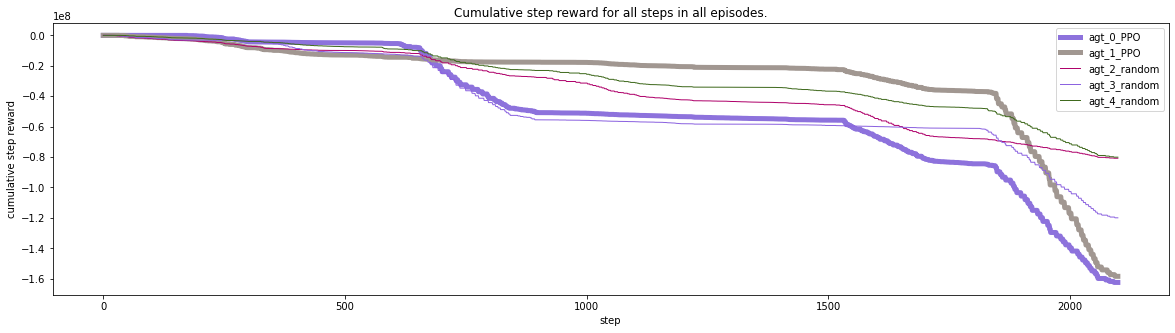

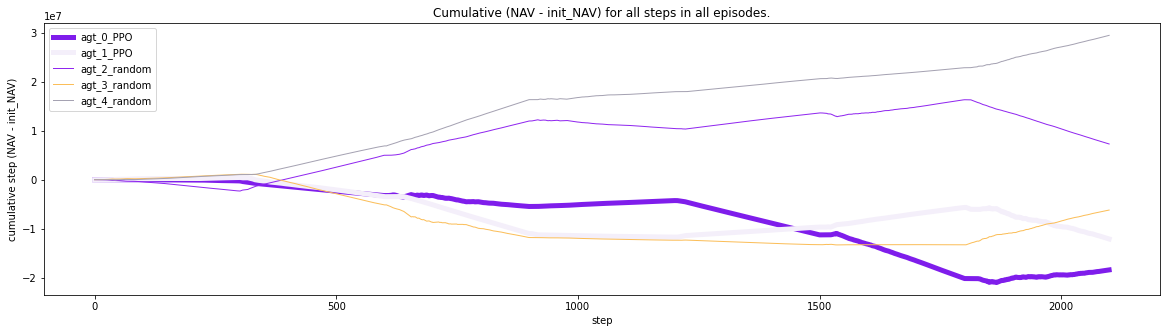

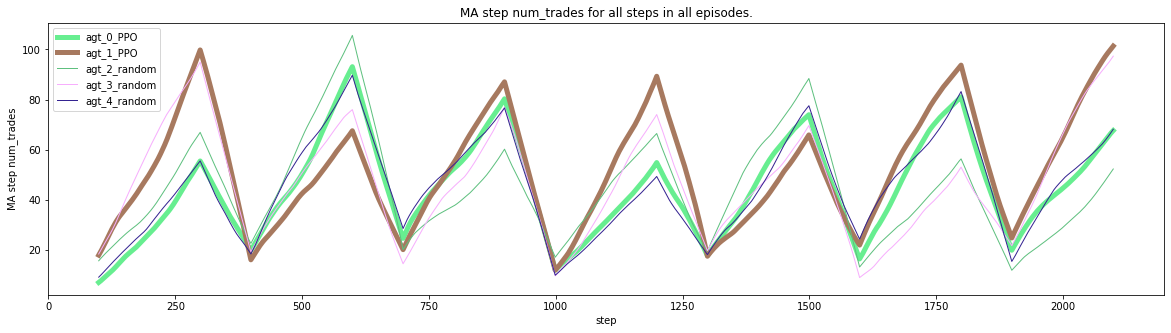

In [22]:
# Plot step results
plot_step_result(init_cash, num_agents, num_trained_agent, "reward", reward_step_store, 'agt_', '_reward_step_list', '_PPO', 'step', 'cumulative step reward', 'Cumulative step reward for all steps in all episodes.')
plot_step_result(init_cash, num_agents, num_trained_agent, "NAV", NAV_step_store, 'agt_', '_NAV_step_list', '_PPO', 'step', 'cumulative step (NAV - init_NAV)', 'Cumulative (NAV - init_NAV) for all steps in all episodes.')
plot_step_result(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_step_store, 'agt_', '_num_trades_step_list', '_PPO', 'step', 'MA step num_trades', 'MA step num_trades for all steps in all episodes.') 

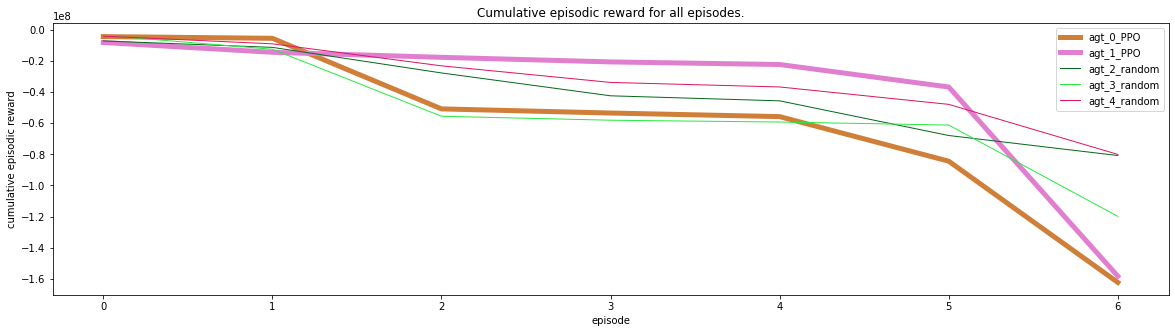

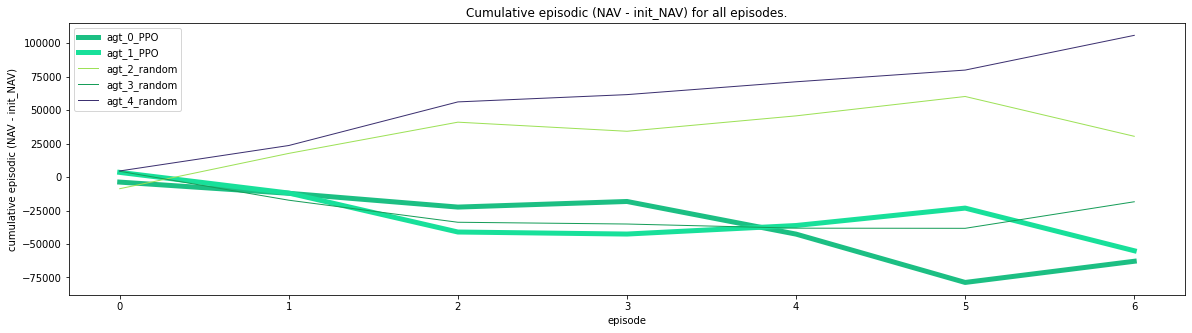

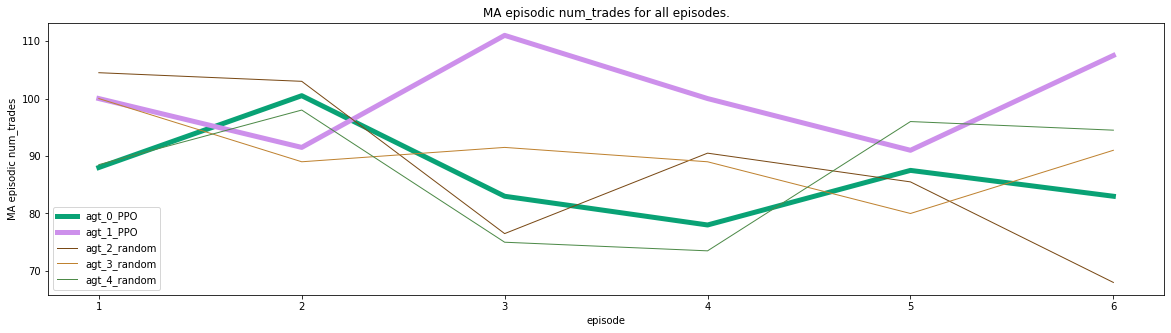

In [23]:
# Plot episodic results
plot_eps_result(init_cash, num_agents, num_trained_agent, "reward", policy_reward_store, 'agt_', '_policy_reward_list', '_PPO', 'episode','cumulative episodic reward', 'Cumulative episodic reward for all episodes.')
#plot_eps_result(init_cash, num_agents, num_trained_agent, "reward", reward_store, 'agt_', '_reward_list', '_PPO', 'episode','cumulative episodic raw reward') # last step raw reward, unlike policy_reward_store which is total reward/eps.
plot_eps_result(init_cash, num_agents, num_trained_agent, "NAV", NAV_store, 'agt_', '_NAV_list', '_PPO', 'episode','cumulative episodic (NAV - init_NAV)', 'Cumulative episodic (NAV - init_NAV) for all episodes.')
plot_eps_result(init_cash, num_agents, num_trained_agent, "num_trades", num_trades_store, 'agt_', '_num_trades_list', '_PPO', 'episode','MA episodic num_trades', 'MA episodic num_trades for all episodes.')   

In [24]:
obs_store = create_storage(num_agents, "agt_", "_obs_list")
act_store = create_storage(num_agents, "agt_", "_act_list")

load_json(write_dir, max_step, obs_store, act_store)

0_0_18527766.txt
1_1_18527766.txt
2_2_18527766.txt
3_3_18527766.txt
4_4_18527766.txt
5_0_328902742.txt
6_1_328902742.txt
7_2_328902742.txt
8_3_328902742.txt
9_4_328902742.txt
10_0_117891763.txt
11_1_117891763.txt
12_2_117891763.txt
13_3_117891763.txt
14_4_117891763.txt
15_0_221218563.txt
16_1_221218563.txt
17_2_221218563.txt
18_3_221218563.txt
19_4_221218563.txt
20_0_804808330.txt
21_1_804808330.txt
22_2_804808330.txt
23_3_804808330.txt
24_4_804808330.txt
25_0_1724268686.txt
26_1_1724268686.txt
27_2_1724268686.txt
28_3_1724268686.txt
29_4_1724268686.txt
30_0_372993284.txt
31_1_372993284.txt
32_2_372993284.txt
33_3_372993284.txt
34_4_372993284.txt
35_0_949040496.txt
36_1_949040496.txt
37_2_949040496.txt
38_3_949040496.txt
39_4_949040496.txt


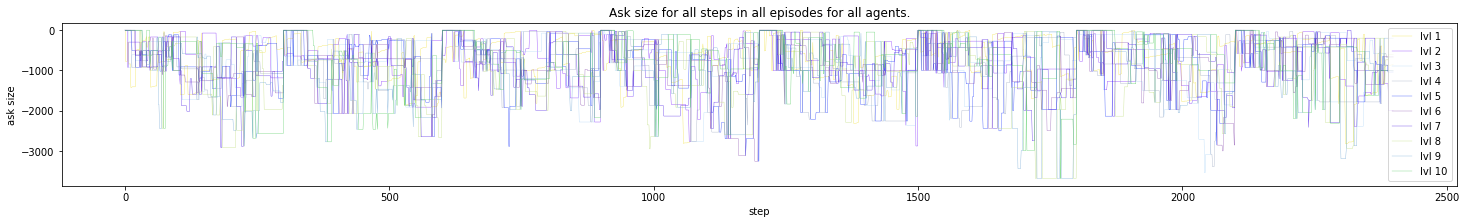

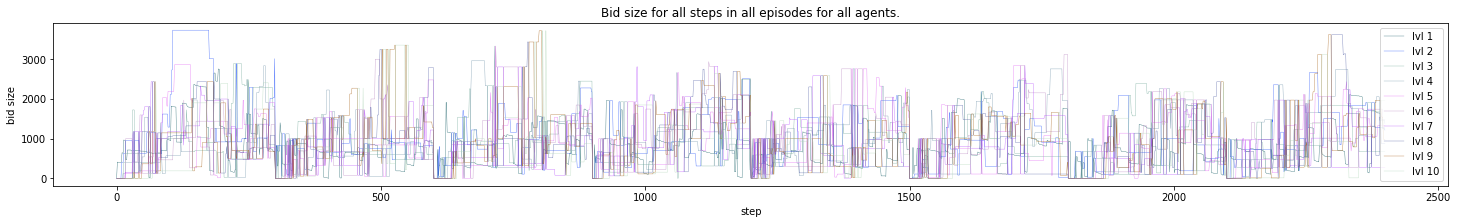

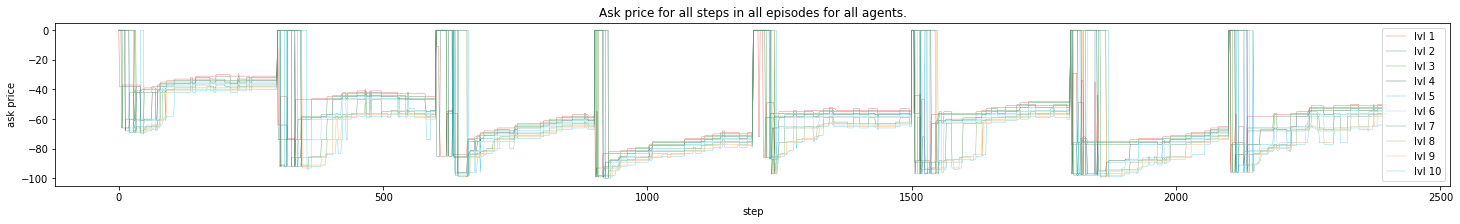

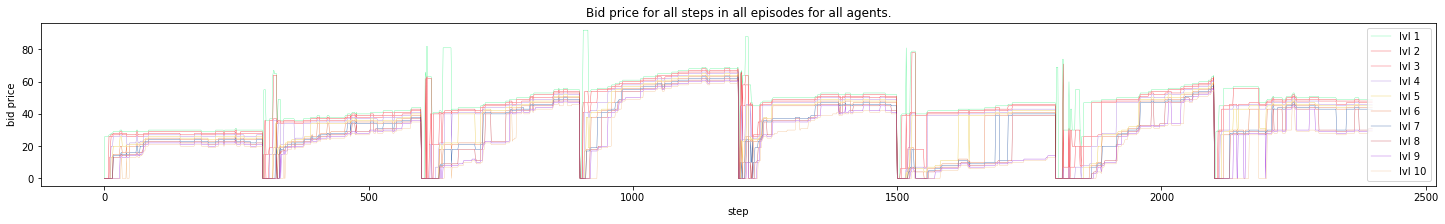

In [25]:
show_obs(obs_store)